In [5]:
import matplotlib.pyplot as plt
import numpy as np


def sigma_brs (t, tau, T, a,b,c):
    u = (a**2/(T - tau + b) - 2*a*c*np.log(T - tau + b) + c**2*tau) 
    l = (a**2/(T - t + b) - 2*a*c*np.log(T - t + b) + c**2*t) 
    var = (u-l)/(tau-t)
    return(np.sqrt(var))

def integral_brs(s,T, a, b,c):
    return(a**2/(T - s + b) - 2*a*c*np.log(T - s + b) + c**2*s)

def sigma_factor1(t, tau ,T, a, b):
    u = (a**2/(T - tau + b))
    l = (a**2/(T - t + b))
    var = (u-l)/(tau-t)
    return(np.sqrt(var))

def sigma_factor2(t, tau,T, a, b,c):
    u = (- 2*a*c*np.log(T - tau + b))
    l = (- 2*a*c*np.log(T - t + b))
    var = (u-l)/(tau-t)
    return(np.sqrt(var))


def sigma_factor3(t, tau,T,c):
    u = (c**2*tau)
    l = (c**2*t)
    var = (u-l)/(tau-t)
    return(np.sqrt(var))


def volatility(t, tau, T, a,  b, c):
    upper_integral = integral_brs(tau, T, a,b,c ) 
    lower_integral = integral_brs(t, T, a,b,c ) 
    variance =  (upper_integral - lower_integral)/(tau-t)
    return np.sqrt(variance)



In [11]:

t = 0
T = 1 
tau =1/12
a= 0.9
b = 0.6
c= 0.1
    
vol = volatility(t, tau, T, a,b,c)
vol2 = sigma_brs(t, tau, T, a,b,c)

print("volatility:"+ str(vol))
print("volatility2:"+ str(vol2))
print("Variance:"+ str(vol**2))
print("Variance2:"+ str(vol2**2))


f1 = sigma_factor1(t, tau, T, a,b)
f2 = sigma_factor2(t, tau, T, a,b,c)
f3 = sigma_factor3(t, tau, T, c)

print("SumVariance:"+ str((f1**2+f2**2+f3**2)))


volatility:0.6777365035803672
volatility2:0.6777365035803672
Variance:0.4593267682853411
Variance2:0.4593267682853411
SumVariance:0.45932676828534064


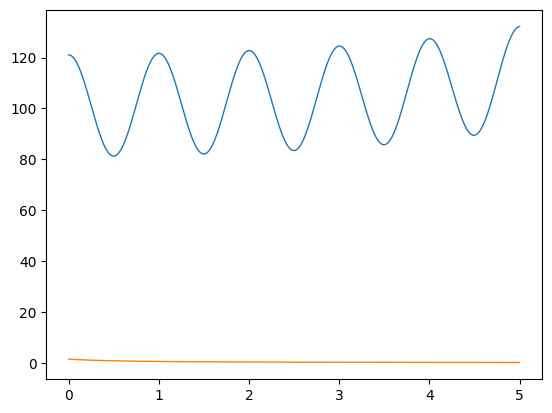

In [14]:

def term_structure(t, T_max=5.0):
    # Define a term structure function that could depend on t
    # Simple sinusoidal term structure for demonstration
    return 100 + 20 * np.cos(2*T_max * np.pi * t /T_max) + np.exp(0.5*t)

def vol_structure(t, T, a= 0.9, b = 0.6, c= 0.1):
    return a / (t + b) + c

# Parameters 
T = 5  # Total time in years
dt = 1/252  # Daily time step
n_steps = int(T / dt)

taus = np.arange(0, n_steps + 1) * dt  # Time steps

plt.plot(taus, term_structure(taus, T), lw=1, label='Term Structure')
plt.plot(taus, vol_structure(taus, T), lw=1, label='Volatility Structure')

## Simulation

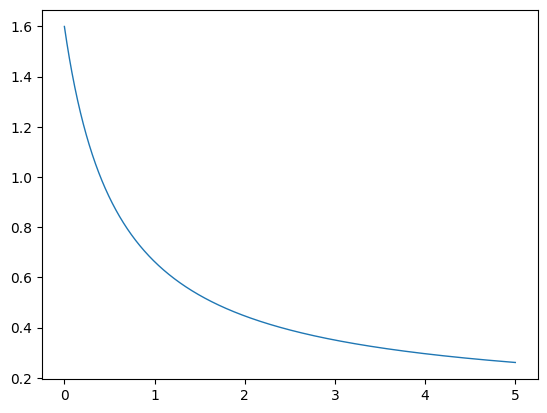

In [ ]:
# Parameters 
T = 5  # Total time of the simulation in years
F0 = term_structure(0)  # Initial forward price using the term structure
dt = 1/252  # Daily time step
paths = 1000  # Number of paths to simulate
n_steps = int(T / dt)

taus = np.arange(0, n_steps + 1) * dt  # Time steps

#plt.plot(taus, term_structure(taus, T), lw=1, label='Term Structure')
plt.plot(taus, vol_structure(taus, T), lw=1, label='Term Structure')

# Generate independent random samples
independent_samples = np.random.randn(n_sims, 1)

Int1 = 0
Int2 = 0
Int3 = 0

#F1 = F0 * np.exp(Int1 * rand1 - 0.5 * Int1**2) * np.exp(Int2 * rand2 - 0.5 * Int2**2) * np.exp(Int3 * rand3 - 0.5 * Int3**2)
